In [1]:
import os
import matplotlib.pyplot as plt
from backtests import fetch_portfolio_states, start_backtest, wait_for_backtest, BacktestRequest, analyze_backtest, BacktestAnalysis, get_backtest_ids
from strategy import get_strategy_names, set_strategy_parameters, get_strategy_parameters

In [2]:
def plot_portfolio_value(assets_states, save_name=None, show=True):
    portfolio_values = [state.assets.equityValue for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    if save_name is not None:
        os.makedirs("plots", exist_ok=True)
        plt.savefig(f"plots/{save_name}.png", transparent=True)
    
    if show:
        plt.show()
        
    if (save_name is not None) or show:
        plt.clf()

In [3]:
def plot_num_of_positions(assets_states):
    portfolio_values = [len(state.assets.positions) for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Positions')
    plt.show()

In [4]:
def print_investments(investments):
    for inv in investments:
        print(f"{inv.symbol}: {inv.exit_value / inv.entry} ({inv.start} to {inv.end})")

In [5]:
def print_analysis(name, analysis_details):
    print(f"-> BACKTEST {name}")
    print(f"\tReturn:                     {(analysis_details.total_return*100):.3f}%")
    print(f"\tInvestments:                {analysis_details.investments_count}")
    print(f"\t Avg investment length:     {analysis_details.avg_investment_length:.3f} days")
    print(f"\t Positive investment ratio: {(analysis_details.positive_investment_ratio * 100):.2f}%")

In [6]:
def run_backtests_for_strategies(symbols, skip, prediction_error, strategies=None):
    def make_request(strategy):
        return BacktestRequest(
            strategy=strategy,
            symbols=symbols,
            skip=skip,
            use_predictor=False,
            avg_prediction_error=prediction_error
        )
    
    if strategies is None:
        strategies = get_strategy_names()
    
    for strategy_name in strategies:
        backtest_id = start_backtest(make_request(strategy_name))
        wait_for_backtest(backtest_id)
        analysis = analyze_backtest(backtest_id)
        
        name=f"err_{(prediction_error*100):.2f}_{strategy_name.lower().replace(' strategy', '').replace(' ', '_')}"
        print_analysis(name, analysis)
        plot_portfolio_value(analysis.portfolio_states, name, show=False)

In [7]:
def run_backtests_with_folds(prediction_error, strategies=None):
    def make_request(name, fold):
        return BacktestRequest(
            strategy=name,
            symbols=1100,
            skip=fold*1100,
            use_predictor=False,
            avg_prediction_error=prediction_error
        )
    
    if strategies is None:
        strategies = get_strategy_names()
    
    folds = list(range(5))
    for strategy_name in strategies:
        analysis_results = []
        for fold in folds:
            backtest_id = start_backtest(make_request(strategy_name, fold))
            wait_for_backtest(backtest_id)
            analysis_results.append(
                analyze_backtest(backtest_id)
            )
            
        combined_details = BacktestAnalysis(
            total_return=sum(a.total_return for a in analysis_results) / len(analysis_results),
            investments_count=sum(a.investments_count for a in analysis_results) / len(analysis_results),
            avg_investment_length=sum(a.avg_investment_length for a in analysis_results) / len(analysis_results),
            positive_investment_ratio=sum(a.positive_investment_ratio for a in analysis_results) / len(analysis_results),
            portfolio_states=None,
            investments=None
        )
        
        print_analysis(f"folds_err_{(prediction_error*100):.2f}_{strategy_name.lower().replace(' strategy', '').replace(' ', '_')}", combined_details)

### Strategy backtests 

In [ ]:
run_backtests_for_strategies(symbols=-1, skip=0, prediction_error=0)

In [ ]:
run_backtests_with_folds(prediction_error=0)

In [ ]:
for error in [0.01, 0.05, 0.1, 0.2]:
    run_backtests_with_folds(prediction_error=error)

In [ ]:
for error in [0.01, 0.05, 0.1, 0.2]:
    run_backtests_for_strategies(symbols=-1, skip=0, prediction_error=error, strategies=[
        "Basic strategy",
        "Greedy optimal strategy",
        "Overreaction strategy with predictions",
        "Trend following strategy with predictions",
        "PCA strategy with predictions"
    ])

### Plots

In [2]:
all_backtests = get_backtest_ids()

In [6]:
{k: v for k, v in all_backtests.items() if "(0/-1)" in k and " 0.000%" in k}

{'Greedy optimal strategy (0/-1): 0.000% mean error': 'ccc27072-9fec-4728-8954-3fbff23eb077',
 'Basic strategy (0/-1): 0.000% mean error': 'ee6113e2-90b8-40d4-b72e-43d9bf214012',
 'Overreaction strategy (0/-1): 0.000% mean error': '3c1df575-6813-4baf-9c5b-020b0d3a041a',
 'Overreaction strategy with predictions (0/-1): 0.000% mean error': '4c420c0f-22ec-4e5c-b6c7-7d36b19e51aa',
 'Trend following strategy with predictions (0/-1): 0.000% mean error': '89ffe84b-82fa-43be-bf8b-c0078a97a003',
 'PCA strategy (0/-1): 0.000% mean error': '437bcd3b-f846-4a71-b2eb-0cd8626a1916',
 'PCA strategy with predictions (0/-1): 0.000% mean error': '721406c3-5d3e-4ffe-9eb1-1ae4eb2ae302',
 'Trend following strategy (0/-1): 0.000% mean error': 'e00a4317-a327-41b2-9464-abab72257c8a'}

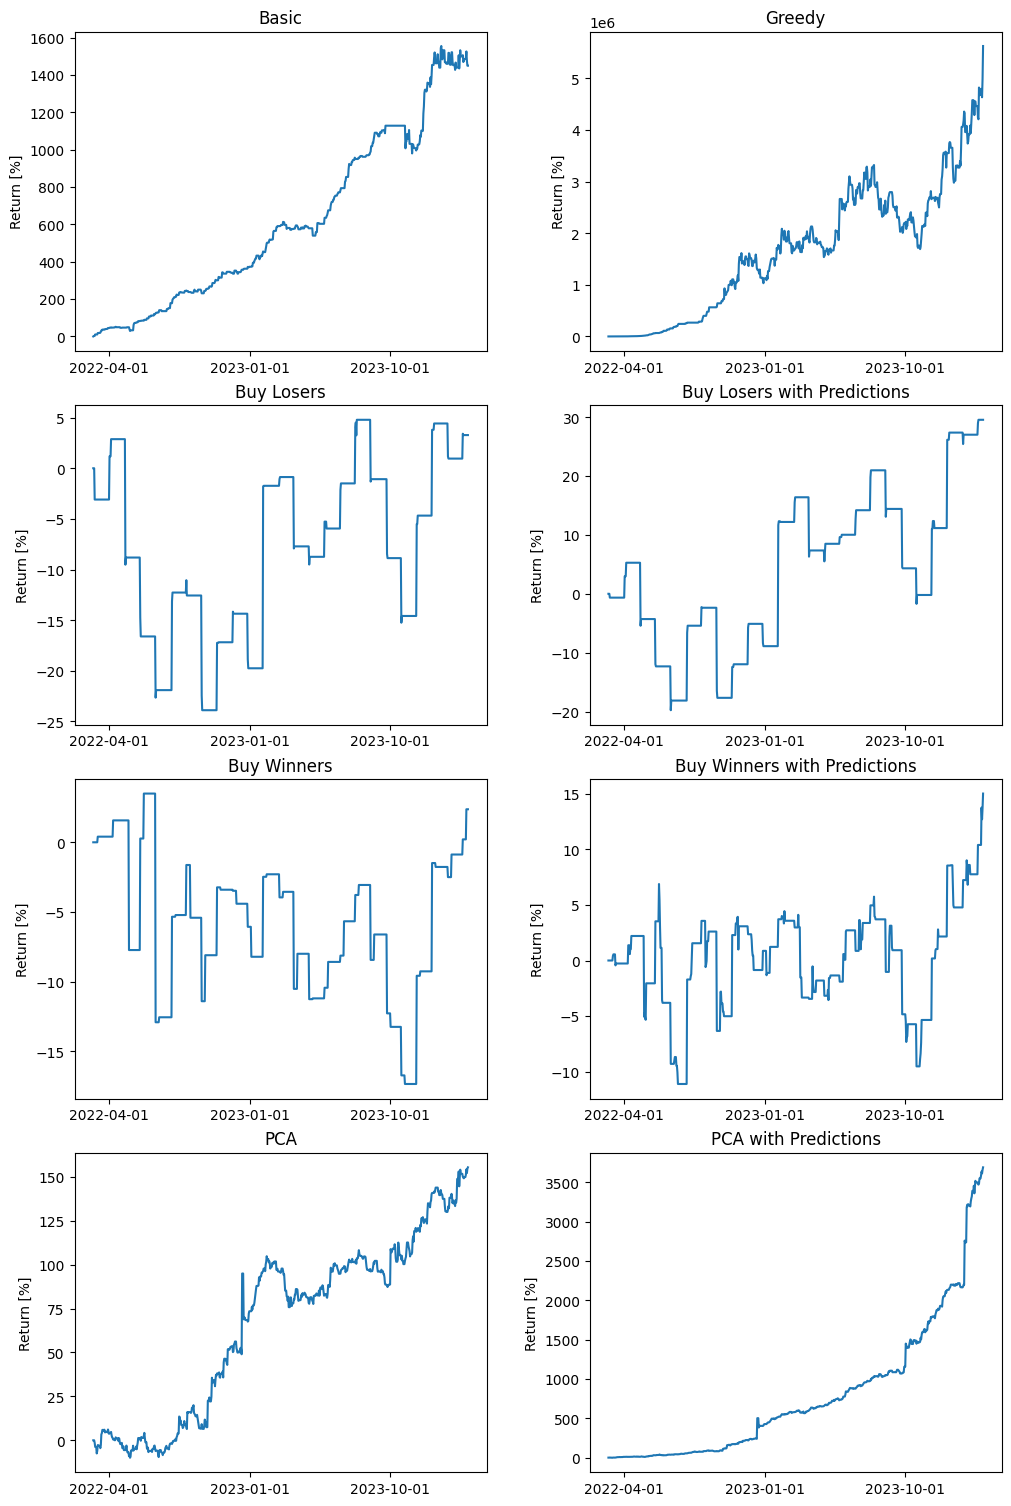

In [19]:
backtests_per_strategy = {
    "Basic": "ee6113e2-90b8-40d4-b72e-43d9bf214012",
    "Greedy": "0c3702fe-e897-4f9b-a166-f93ea5474d5f",
    "Buy Losers": "3c1df575-6813-4baf-9c5b-020b0d3a041a",
    "Buy Losers with Predictions": "cd6e9e59-3a09-4ae1-9850-57f16e248f74",
    "Buy Winners": "e00a4317-a327-41b2-9464-abab72257c8a",
    "Buy Winners with Predictions": "89ffe84b-82fa-43be-bf8b-c0078a97a003",
    "PCA": "437bcd3b-f846-4a71-b2eb-0cd8626a1916",
    "PCA with Predictions": "721406c3-5d3e-4ffe-9eb1-1ae4eb2ae302"
}

def make_subplot(axis, title):
    backtest_id = backtests_per_strategy[title]
    
    axis.set_title(title)
    axis.set_ylabel("Return [%]")
    
    assets_states = fetch_portfolio_states(backtest_id)
    portfolio_values = [state.assets.equityValue / 1000 - 100 for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    axis.plot(dates, portfolio_values)
    axis.set_xticks(axis.get_xticks()[::3])

figure, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
figure.tight_layout()

make_subplot(axes[0, 0], "Basic")
make_subplot(axes[0, 1], "Greedy")
make_subplot(axes[1, 0], "Buy Losers")
make_subplot(axes[1, 1], "Buy Losers with Predictions")
make_subplot(axes[2, 0], "Buy Winners")
make_subplot(axes[2, 1], "Buy Winners with Predictions")
make_subplot(axes[3, 0], "PCA")
make_subplot(axes[3, 1], "PCA with Predictions")

plt.subplots_adjust(hspace=0.17, wspace=0.25)
plt.show()

### Bayes search

In [20]:
from bayes import perform_bayes_search
from skopt.space import Real, Integer

params_per_strategy = {
    "Basic strategy": {
        "maxStocksBuyCount": Integer(low=1, high=20),
        "minDaysDecreasing": Integer(low=1, high=5),
        "minDaysIncreasing": Integer(low=1, high=5),
        "topGrowingSymbolsBuyRatio": Real(low=0.1, high=0.9),
        "limitPriceDamping": Real(low=0.1, high=0.9)
    },
    "Overreaction strategy": {
        "evaluationFrequencyInDays": Integer(low=7, high=90),
        "analysisLengthInDays": Integer(low=7, high=90),
        "limitPriceDamping":Real(low=0.1, high=0.9)
    },
    "Trend following strategy": {
        "evaluationFrequencyInDays": Integer(low=30, high=90),
        "analysisLengthInDays": Integer(low=30, high=360),
        "simultaneousEvaluations": Integer(low=1, high=5),
        "buyWaitTimeInDays": Integer(low=0, high=14),
        "limitPriceDamping": Real(low=0.1, high=0.9)
    },
    "PCA strategy": {
        "varianceFraction": Real(low=0.95, high=0.99),
        "analysisLengthInDays": Integer(low=30, high=360),
        "decompositionExpirationInDays": Integer(low=3, high=20),
        "undervaluedThreshold": Real(low=0.5, high=3),
        "ignoredThreshold": Real(low=0.1, high=1),
        "diverseThreshold": Real(low=0.1, high=1),
        "limitPriceDamping": Real(low=0.1, high=0.9)
    }
}

results = {}
for strategy, params in params_per_strategy.items():
    best_params, best_score = perform_bayes_search(
        strategy,
        params,
        10,
        prediction_error=0,
        symbols=200,
        folds=5
    )
    
    results[strategy] = (best_score, best_params)
    
    print(f"{strategy}: {(best_score*100):.2f}% for {best_params}")

Running a backtest with params: {'limitPriceDamping': 0.3223690836683728, 'maxStocksBuyCount': 8, 'minDaysDecreasing': 5, 'minDaysIncreasing': 5, 'topGrowingSymbolsBuyRatio': 0.8402263506089461}
Waiting for backtest 1230564c-4036-4bd2-8a38-43f111a19169
Waiting for backtest 782063d2-242c-4161-8ee1-08a7ec690dee
Waiting for backtest 85eb3f98-a8c2-4589-bcea-c7809eecb487
Waiting for backtest ebd40468-01fd-4124-92d7-14a124049495
Waiting for backtest 30efee56-fe97-4b40-9b00-19af45ded199
Running a backtest with params: {'limitPriceDamping': 0.466883816048419, 'maxStocksBuyCount': 3, 'minDaysDecreasing': 2, 'minDaysIncreasing': 3, 'topGrowingSymbolsBuyRatio': 0.6349461266463036}
Waiting for backtest 8ec69f53-7f98-4082-8c69-19c6349aaeec
Waiting for backtest 77447201-6d21-4cee-85ab-edd3df13c17f
Waiting for backtest afddd3cf-a49a-4761-a25c-491ac7c69bec
Waiting for backtest 9ec2f0cd-d8f8-496d-b9a4-d28dce522aec
Waiting for backtest f61f9e1e-9b21-4763-b2bf-0110a4dc2c67
Running a backtest with params: